<p align="center">
  <h1 align="center">Recipe recommendation system</h1>
  <h4 align="center">
    <strong>Jelle Huibregtse</strong> and <strong>Aron Hemmes</strong>
  </h4>
</p>

## The Assignment
The goal is to ultimately create a personalized recipe recommendation system that learns from the choices of its users.

### Loading in some libraries

In [1]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = 10, 5

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


## Machine Learning (ML)
First, we import the cleaned datasets from the previous notebook (DCA).

In [2]:
df_ingredient = pd.read_csv('export/ingredient.csv')
# Set the index to ingredient id.
df_ingredient = df_ingredient.set_index('ingredient_id')
df_ingredient.head()

,category,name,plural
ingredient_id,,,
1,dairy,1% lowfat cottage cheese,NaN
6,dairy,1% lowfat milk,NaN
10,Mexican products,10-inch flour tortilla,s
11,cereals,100% bran cereal,NaN
12,dairy,2% lowfat milk,NaN


In [3]:
df_quantity = pd.read_csv('export/quantity.csv')
# Set the index to ingredient id.
df_quantity = df_quantity.set_index('quantity_id')
df_quantity.head()

,recipe_id,ingredient_id,max_qty,min_qty,unit,preparation,optional
quantity_id,,,,,,,
1,214,1613,2.00,2.00,cup(s),NaN,False
2,214,3334,0.25,0.25,cup(s),NaN,False
3,214,2222,0.50,0.50,cup(s),melted,False
4,214,2797,0.25,0.25,cup(s),or water,False
5,214,3567,3.00,3.00,teaspoon(s),NaN,False


In [4]:
df_recipe = pd.read_csv('export/recipe.csv')
# Set the index to ingredient id.
df_recipe = df_recipe.set_index('recipe_id').sort_values(by='recipe_id')
df_recipe

,title,subtitle,servings,yield_unit,prep_min,cook_min,total_min,stnd_min,intro,directions,...,cholestrl,sodium,iron,vitamin_c,vitamin_a,fiber,pcnt_cal_carb,pcnt_cal_fat,pcnt_cal_prot,calories
recipe_id,,,,,,,,,,,,,,,,,,,,,
214,Raspberry Chiffon Pie,NaN,10,1 pie,20,8,28,305,NaN,"For crust, preheat oven to 375 degrees F.\nIn...",...,1.39,260.78,0.81,8.89,586.20,0.87,56.80,35.68,7.53,290.79
215,Apricot Yogurt Parfaits,NaN,4,NaN,5,2,7,65,NaN,"Drain canned apricots, pour 1/4 cup of the ju...",...,3.48,46.17,0.57,13.02,2738.24,0.62,67.38,6.89,16.17,141.01
216,Fresh Apricot Bavarian,NaN,8,NaN,5,13,18,0,Serve in stemmed glasses and top with sliced a...,Drop apricots into boiling water to cover. R...,...,3.46,41.79,0.37,6.13,1521.10,0.34,78.45,7.24,14.30,137.06
217,Fresh Peaches,with Banana Cream Whip,4,NaN,10,0,10,0,"For a quick, low-cal dessert, serve this on o...","In a small bowl, beat egg white until foamy. ...",...,0.00,14.01,0.19,8.79,478.09,0.69,88.98,2.35,8.67,81.70
218,Canned Cherry Crisp,NaN,6,NaN,10,5,15,0,Your microwave turns a can of cherry pie filli...,"Pour cherry pie filling into an 8-inch, round...",...,10.36,50.22,0.66,0.16,229.16,1.05,72.81,24.46,2.73,201.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,-Waffles-,NaN,8,8 waffles,10,15,25,0,NaN,Preheat waffle iron according to manufacturer...,...,60.38,173.88,0.59,0.51,147.61,0.10,44.57,45.71,9.72,270.50
1428,-French Toast-,NaN,4,NaN,5,10,15,0,"If you have day-old or stale bread on hand, t...",Beat egg with milk in a large soup bowl or pi...,...,144.36,458.80,1.80,0.39,644.66,0.10,38.83,49.31,11.86,308.10
1429,-Mixed Green Salad-,NaN,4,NaN,0,0,0,0,NaN,NaN,...,0.00,15.34,1.00,22.68,4048.92,0.20,61.69,11.73,26.59,20.31


### User dataset
We create an initial dataset for the recipes of a user to learn from.

In [5]:
df_user_recipe = pd.DataFrame(
    {'recipe_id': [549, 457, 680, 1432, 1063, 1151, 476, 654, 525, 773],
     'rating': [8, 5, 6, 7, 7, 3, 6, 8, 7, 9],
     'date_of_consumption': ['2021-05-10', '2021-05-08', '2021-05-08', '2021-05-05', '2021-05-04', '2021-05-06', '2021-05-11', '2021-05-02', '2021-05-01', '2021-05-03']})
df_user_recipe = df_user_recipe.sort_values(by='date_of_consumption', ascending=False)
df_user_recipe

,recipe_id,rating,date_of_consumption
6,476,6,2021-05-11
0,549,8,2021-05-10
1,457,5,2021-05-08
2,680,6,2021-05-08
5,1151,3,2021-05-06
3,1432,7,2021-05-05
4,1063,7,2021-05-04
9,773,9,2021-05-03
7,654,8,2021-05-02
8,525,7,2021-05-01


### Nutrional guidelines
First create a dataframe for nutritional guidelines of an adult male 20 yrs, that weighs 60 kg.

ref: https://www.nutrition.org.uk/attachments/article/234/Nutrition%20Requirements_Revised%20Oct%202016.pdf

In [6]:
df_intake = pd.DataFrame(
    {'nutrition': ['protein', 'carbo', 'total_fat', 'sodium', 'iron', 'vitamin_c', 'vitamin_a', 'calories'],
     'intake': [45, 260, 70, 1600, 9.7, 40, 700, 2772],
     'measurement': ['g/d', 'g/d', 'g/d', 'mg^d^2', 'mg/d', 'mg/d', 'µg/d', 'kcal/d']})
df_intake

,nutrition,intake,measurement
0,protein,45.0,g/d
1,carbo,260.0,g/d
2,total_fat,70.0,g/d
3,sodium,1600.0,mg^d^2
4,iron,9.7,mg/d
5,vitamin_c,40.0,mg/d
6,vitamin_a,700.0,µg/d
7,calories,2772.0,kcal/d


### Healthy recommendation
Recommend recipes based on user recipes and daily reference intakes

In [7]:
# Filter recipes in last 7 recorded days
days = pd.unique(df_user_recipe.sort_values(by='date_of_consumption')['date_of_consumption'])[-7:]

# Getting total nutrition values of days
total_protein = 0
total_carbo = 0
total_total_fat = 0
total_sodium = 0
total_iron = 0
total_vitamin_c = 0
total_vitamin_a = 0
total_calories = 0

for i, row in df_user_recipe.iterrows():
    if row.date_of_consumption in days and row.recipe_id in df_recipe.index:
        recipe = df_recipe.loc[df_recipe.index == row.recipe_id]
        total_protein += recipe.protein.values[0]
        total_carbo += recipe.carbo.values[0]
        total_total_fat += recipe.total_fat.values[0]
        total_sodium += recipe.sodium.values[0]
        total_iron += recipe.iron.values[0]
        total_vitamin_c += recipe.vitamin_c.values[0]
        total_vitamin_a += recipe.vitamin_a.values[0]
        total_calories += recipe.calories.values[0]

print('protein:', total_protein)
print('carbo:', total_carbo)
print('total_fat:', total_total_fat)
print('sodium:', total_sodium)
print('iron:', total_iron)
print('vitamin_c:', total_vitamin_c)
print('vitamin_a:', total_vitamin_a)
print('calories:', total_calories)

# Recommend recipes ascending by nutrition value
health_recommendation_data = []

for i, row in df_recipe.iterrows():
    total_nutrition = (total_protein + row.protein) / (len(days) + 1)
    total_nutrition += (total_carbo + row.carbo) / (len(days) + 1)
    total_nutrition += (total_total_fat + row.total_fat) / (len(days) + 1)
    total_nutrition += (total_sodium + row.sodium) / (len(days) + 1)
    total_nutrition += (total_iron + row.iron) / (len(days) + 1)
    total_nutrition += (total_vitamin_c + row.vitamin_c) / (len(days) + 1)
    total_nutrition += (total_vitamin_a + row.vitamin_a) / (len(days) + 1)
    total_nutrition += (total_calories + row.calories) / (len(days) + 1)
    rating = 1 - abs(1 - total_nutrition / df_intake.intake.sum())
    health_recommendation_data.append(rating)

df_health_recommendation = df_recipe
df_health_recommendation['rating'] = health_recommendation_data
df_health_recommendation = df_health_recommendation.sort_values(by='rating', ascending=0)
df_health_recommendation

protein: 130.73
carbo: 384.46999999999997
total_fat: 45.57
sodium: 3038.4099999999994
iron: 28.480000000000004
vitamin_c: 562.0
vitamin_a: 42794.71000000001
calories: 2471.04


,title,subtitle,servings,yield_unit,prep_min,cook_min,total_min,stnd_min,intro,directions,...,sodium,iron,vitamin_c,vitamin_a,fiber,pcnt_cal_carb,pcnt_cal_fat,pcnt_cal_prot,calories,rating
recipe_id,,,,,,,,,,,,,,,,,,,,,
856,-Tea-,NaN,4,NaN,5,0,5,0,NaN,"Serve hot or chilled, over ice.",...,0.15,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.06,0.875334
857,-Coffee-,NaN,4,NaN,10,0,10,0,NaN,Brew coffee according to coffee maker directi...,...,0.57,0.01,0.00,0.00,0.00,80.00,0.00,20.00,0.57,0.875309
860,-Herb Tea-,NaN,4,NaN,5,0,5,0,NaN,NaN,...,2.27,0.18,0.00,0.00,0.00,81.63,18.37,0.00,2.23,0.875221
899,-Brown Sugar-,NaN,4,NaN,0,0,0,0,NaN,Use to top hot cereal or to add to beverages.,...,0.75,0.09,0.00,0.00,0.00,100.00,0.00,0.00,9.67,0.875045
782,-Dates-,NaN,4,NaN,5,0,5,0,NaN,"Serve whole, as a garnish or stuffed with cre...",...,0.12,0.05,0.00,2.00,0.09,96.10,1.32,2.58,12.24,0.874942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,Sherried Sweet Potatoes,with Pecans,6,NaN,5,50,55,0,A Southern side dish that's always delicious.,Boil the sweet potatoes in salted water until...,...,64.78,1.40,45.16,26298.02,2.49,58.45,34.48,3.75,430.44,0.263080
512,Cherry Sweet Potatoes,NaN,6,NaN,5,30,35,0,Turned canned ingredients into a quick side dish.,"In a mixing bowl, combine cherry filling, all...",...,27.44,1.07,31.23,27621.31,1.71,93.64,2.34,4.02,267.50,0.238262
1022,Turkey Pot Roast,NaN,4,NaN,20,75,95,0,NaN,Use 1 to 2 pound turkey thighs. Rinse turkey...,...,837.87,6.60,36.51,30551.72,2.62,40.25,20.41,39.34,520.61,0.146067


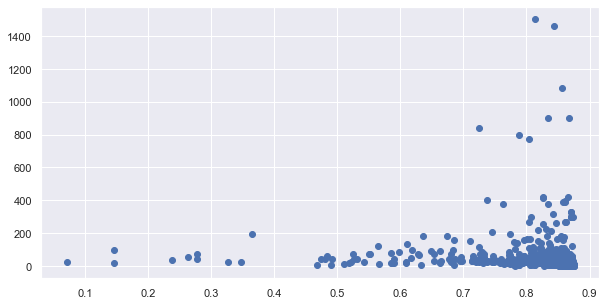

In [8]:
plt.scatter(df_health_recommendation.rating, df_health_recommendation.total_min);

### K-Means Clustering

K-means clustering is one of the most popular unsupervised machine learning algorithm. It is used to uncover categories within a dataset. k represents the number of categories identified, we need to find this value. For this we can use the elbow method. In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. Which is exactly what we need. We calculate the Within-Cluster-Sum of Squared Errors (SSE) for different k values, and choose the k for which SSE becomes first start to diminish. We can more clearly see this in a plot, we look at an elbow. The Squared Error for each point is the square of the distance of the point its representation i.e. its predicted cluster center. Any distance metric (Euclidean or Manhattan) can be used here.

In [9]:
def calculate_SSE(data, kmax):
    sse = []
    for k in range(1, kmax):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        
    return sse

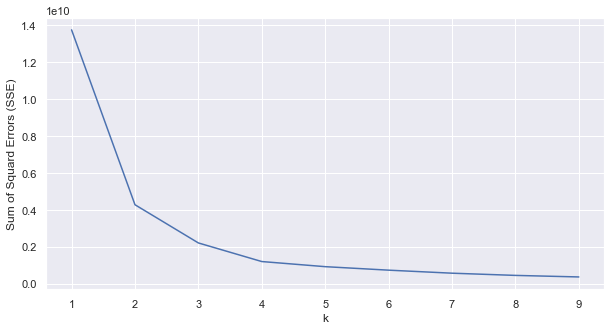

In [10]:
kmax = 10
sse = calculate_SSE(
    df_health_recommendation[['protein', 'carbo', 'sodium', 'iron', 'vitamin_c', 'vitamin_a', 'calories']],
    kmax)

plt.xlabel('k')
plt.ylabel('Sum of Squard Errors (SSE)')
plt.plot(range(1, 10), sse);

We can clearly see an elbow at $k = 5$. We can now add each recipe to a cluster.

In [11]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_health_recommendation[['protein', 'carbo', 'sodium', 'iron', 'vitamin_c', 'vitamin_a', 'calories']])
df_health_recommendation['cluster'] = kmeans.labels_
df_health_recommendation

,title,subtitle,servings,yield_unit,prep_min,cook_min,total_min,stnd_min,intro,directions,...,iron,vitamin_c,vitamin_a,fiber,pcnt_cal_carb,pcnt_cal_fat,pcnt_cal_prot,calories,rating,cluster
recipe_id,,,,,,,,,,,,,,,,,,,,,
856,-Tea-,NaN,4,NaN,5,0,5,0,NaN,"Serve hot or chilled, over ice.",...,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.06,0.875334,0
857,-Coffee-,NaN,4,NaN,10,0,10,0,NaN,Brew coffee according to coffee maker directi...,...,0.01,0.00,0.00,0.00,80.00,0.00,20.00,0.57,0.875309,0
860,-Herb Tea-,NaN,4,NaN,5,0,5,0,NaN,NaN,...,0.18,0.00,0.00,0.00,81.63,18.37,0.00,2.23,0.875221,0
899,-Brown Sugar-,NaN,4,NaN,0,0,0,0,NaN,Use to top hot cereal or to add to beverages.,...,0.09,0.00,0.00,0.00,100.00,0.00,0.00,9.67,0.875045,0
782,-Dates-,NaN,4,NaN,5,0,5,0,NaN,"Serve whole, as a garnish or stuffed with cre...",...,0.05,0.00,2.00,0.09,96.10,1.32,2.58,12.24,0.874942,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,Sherried Sweet Potatoes,with Pecans,6,NaN,5,50,55,0,A Southern side dish that's always delicious.,Boil the sweet potatoes in salted water until...,...,1.40,45.16,26298.02,2.49,58.45,34.48,3.75,430.44,0.263080,1
512,Cherry Sweet Potatoes,NaN,6,NaN,5,30,35,0,Turned canned ingredients into a quick side dish.,"In a mixing bowl, combine cherry filling, all...",...,1.07,31.23,27621.31,1.71,93.64,2.34,4.02,267.50,0.238262,1
1022,Turkey Pot Roast,NaN,4,NaN,20,75,95,0,NaN,Use 1 to 2 pound turkey thighs. Rinse turkey...,...,6.60,36.51,30551.72,2.62,40.25,20.41,39.34,520.61,0.146067,1


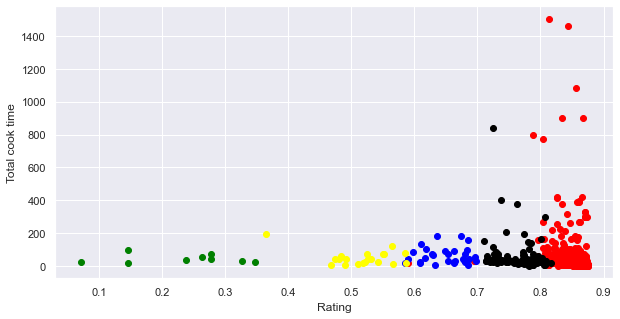

In [12]:
#df_health_recommendation[['total_min', 'rating']]
c1 = df_health_recommendation[df_health_recommendation.cluster == 0]
c2 = df_health_recommendation[df_health_recommendation.cluster == 1]
c3 = df_health_recommendation[df_health_recommendation.cluster == 2]
c4 = df_health_recommendation[df_health_recommendation.cluster == 3]
c5 = df_health_recommendation[df_health_recommendation.cluster == 4]

plt.scatter(c1.rating, c1.total_min, color='red')
plt.scatter(c2.rating, c2.total_min, color='green')
plt.scatter(c3.rating, c3.total_min, color='blue')
plt.scatter(c4.rating, c4.total_min, color='black')
plt.scatter(c5.rating, c5.total_min, color='yellow')

plt.xlabel('Rating')
plt.ylabel('Total cook time');

In [13]:
# Adding reccomended recipe to user recipes
df_user_recipe = df_user_recipe.append({'recipe_id': df_health_recommendation.sort_values(by='rating', ascending=0).index[0], 'rating': np.nan, 'date_of_consumption': datetime.datetime.now().strftime("%Y-%m-%d")}, ignore_index=True).sort_values(by='date_of_consumption', ascending=0)
df_user_recipe

,recipe_id,rating,date_of_consumption
10,856,NaN,2021-05-14
0,476,6.0,2021-05-11
1,549,8.0,2021-05-10
2,457,5.0,2021-05-08
3,680,6.0,2021-05-08
4,1151,3.0,2021-05-06
5,1432,7.0,2021-05-05
6,1063,7.0,2021-05-04
7,773,9.0,2021-05-03
8,654,8.0,2021-05-02


### Rating recommendation
Recommend recipes based on rating a user gave the recipe. We create a `find_cluster` to find what cluster a certain recipe is in.

In [14]:
def find_cluster(recipe_id):
    return df_health_recommendation.loc[df_health_recommendation.index == recipe_id]['cluster'].item() 

find_cluster(1022)

1

In [15]:
def find_rating(recipe_id):
    return df_user_recipe.loc[df_user_recipe.recipe_id == recipe_id]['rating'].item()

Next, we create a recommend_recipe function that takes in the data frame, prefered cluster and rating of a previous recipe. Then returns a recipe based on the cluster or a random one is the rating is lower than 5.

In [16]:
def recommend_recipe(df, cluster, rating):
    X_kmeans = df.copy()
    
    kmeans = KMeans(n_clusters=5)
    y_pred = kmeans.fit_predict(X_kmeans[['protein', 'carbo', 'sodium', 'iron', 'vitamin_c', 'vitamin_a', 'calories']])
    X_kmeans['cluster'] = y_pred
    
    return (X_kmeans[X_kmeans['cluster'] == cluster].sample() if (rating > 5) else X_kmeans.sample(), bool(rating < 5))

In [17]:
from statistics import mode, mean

cluster = mode([find_cluster(id) for id in df_user_recipe.recipe_id.tolist()])

#average rating doesn't work
#average_rating = [find_rating(id) for id in df_user_recipe.recipe_id.tolist()]
#print(average_rating)

recommendation = recommend_recipe(df=df_health_recommendation, cluster=cluster, rating=find_rating(476))
recipe = recommendation[0]
random = recommendation[1]
print(f"We recommend: {recipe['title'].iloc[0]}, which has a rating of {round(recipe['rating'].iloc[0], 2) * 10} (random: {random})")

We recommend: Chocolate Banana Cream Pie, which has a rating of 8.5 (random: False)
